In [1]:
model_folder='/home/mara/multitask_adversarial/results/shallowCNN/'

In [2]:
## Loading OS libraries to configure server preferences
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import setproctitle
SERVER_NAME = 'ultrafast'
EXPERIMENT_TYPE='test_baseline'
import time
import sys
import shutil
## Adding PROCESS_UC1 utilities
sys.path.append('/home/mara/multitask_adversarial/lib/TASK_2_UC1/')
from models import *
from util import otsu_thresholding
from extract_xml import *
from functions import *                   
sys.path.append('/home/mara/multitask_adversarial/lib/')
from mlta import *
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import keras
import sys
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import metrics
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = '0'
keras.backend.set_session(tf.Session(config=config))

verbose=1 

cam16 = hd.File('/home/mara/adversarialMICCAI/data/ultrafast/cam16_500/patches.hdf5',  'r', libver='latest', swmr=True)
all500 = hd.File('/home/mara/adversarialMICCAI/data/ultrafast/all500/patches.hdf5',  'r', libver='latest', swmr=True)
extra17 = hd.File('/home/mara/adversarialMICCAI/data/ultrafast/extra17/patches.hdf5',  'r', libver='latest', swmr=True)
tumor_extra17=hd.File('/home/mara/adversarialMICCAI/data/ultrafast/1129-1155/patches.hdf5', 'r', libver='latest', swmr=True)
test2 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/test_data2/patches.hdf5', 'r', libver='latest', swmr=True)
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches_fix.hdf5', 'r', libver='latest', swmr=True)

global data
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}
global concept_db
concept_db = hd.File('/mnt/nas2/results/IntermediateResults/Mara/MICCAI2020/MELBA_normalized_concepts.hd', 'r')
# Note: nuclei_concepts not supported yet
global nuclei_concepts
nuclei_concepts=hd.File('/mnt/nas2/results/IntermediateResults/Mara/MICCAI2020/normalized_nuclei_concepts_db_new_try_def.hdf5','r')

#SYSTEM CONFIGS 
CONFIG_FILE = 'doc/config.cfg'
COLOR = True
global new_folder
new_folder=folder_name=model_folder
BATCH_SIZE = 32

seed=1
print seed

# SET PROCESS TITLE
setproctitle.setproctitle('UC1_{}'.format(EXPERIMENT_TYPE))

# SET SEED
np.random.seed(seed)
tf.set_random_seed(seed)

# DATA SPLIT CSVs 
train_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/train_shuffle.csv', 'r') # How is the encoding of .csv files ?
val_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/val_shuffle.csv', 'r')
test_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/test_shuffle.csv', 'r')
train_list=train_csv.readlines()
val_list=val_csv.readlines()
test_list=test_csv.readlines()
test2_csv = open('/mnt/nas2/results/IntermediateResults/Camelyon/test2_shuffle.csv', 'r')
test2_list=test2_csv.readlines()
test2_csv.close()
train_csv.close()
val_csv.close()
test_csv.close()
#data_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/data_shuffle.csv', 'r')
#data_csv=open('./data/train.csv', 'r')
data_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/pannuke_train_shuffled.csv', 'r')
data_list=data_csv.readlines()
data_csv.close()

# STAIN NORMALIZATION
def get_normalizer(patch, save_folder=''):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    print('Normalisers saved to disk.')
    return normalizer

def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))
global normalizer
db_name, entry_path, patch_no = get_keys(data_list[0])
normalization_reference_patch = data[db_name][entry_path][patch_no]
normalizer = get_normalizer(normalization_reference_patch, save_folder=new_folder)


"""
Batch generators: 
They load a patch list: a list of file names and paths. 
They use the list to create a batch of 32 samples. 
"""
class Generator(Sequence):
    # Class is a dataset wrapper for better training performance
    def __init__(self, patch_list, batch_size=32):
        #self.x, self.y = x_set, y_set
        self.patch_list=patch_list
        self.batch_size = batch_size
        self.num_samples=len(patch_list)
    def __len__(self):
        return self.num_samples/self.batch_size
    def __getitem__(self, idx):
        while True:
            offset = 0
            batch_size=self.batch_size
            for offset in range(0,self.num_samples, self.batch_size):
                batch_x = []
                batch_y = []
                #batch_ones=[]
                #batch_noise=[]
                batch_contrast = []
                #batch_domain = []
                #batch_n_area = [] # nuclei average area
                batch_n_count = []
                batch_samples=self.patch_list[offset:offset+batch_size]
                for line in batch_samples:
                    db_name, entry_path, patch_no = get_keys(line)
                    patch=data[db_name][entry_path][patch_no]
                    patch=normalize_patch(patch, normalizer)
                    patch=keras.applications.inception_v3.preprocess_input(patch) #removed bc of BNorm
                    #patch=keras.applications.resnet50.preprocess_input(patch) 
                    label = get_class(line, entry_path) # is there a problem with get_class ?
                    batch_x.append(patch)
                    batch_y.append(label)
                batch_x=np.asarray(batch_x, dtype=np.float32)
                batch_y=np.asarray(batch_y, dtype=np.float32)
                batch_cm=np.ones(len(batch_y), dtype=np.float32)
            inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_x = [batch_x, batch_y, batch_cm]
            batch_y = batch_y
            return batch_x, batch_y

    #def on_epoch_end(self):
    #    np.random.shuffle(self.indices)

# Retrieve Concept Measures
def get_concept_measure(db_name, entry_path, patch_no, measure_type=''):
    ### note: The measures in the file should have been scaled beforehand
    # to have zero mean and unit std
    if db_name=='pannuke':
        #import pdb; pdb.set_trace()
        try:
            cm=concept_db[entry_path+'  /'+measure_type][0]
            return cm
        except:
            print "[ERR]: {}, {}, {}, {}".format(db_name, entry_path, patch_no, measure_type)
            return 1.
    else:
        try: 
            cm=concept_db[db_name+'/'+entry_path+'/'+str(patch_no)+'/'+measure_type][0]
            return cm
        except:
            print "[ERR]: {}, {}, {}, {}".format(db_name, entry_path, patch_no, measure_type)
            error_log.write('[get_concept_measure] {}, {}, {}, {}'.format(db_name, entry_path, patch_no, measure_type))
            return 1.
def get_segmented_concept_measure(db_name, entry_path, patch_no, measure_type=''):
    ### note: The measures in the file should have been scaled beforehand
    # to have zero mean and unit std
    try:
        cm = nuclei_concepts[db_name+'/'+entry_path+'/'+str(patch_no)+'/'+measure_type][0]
        return cm
    except:
        print "[ERROR] Error with [get_segmented_concept_measure] {}, {}, {}, {}".format(db_name, entry_path, patch_no, measure_type) 
        #error_log.write('[get_segmented_concept_measure] {}, {}, {}, {}'.format(db_name, entry_path, patch_no, measure_type))
        return 1.
    
# BATCH GENERATORS
def get_batch_data(patch_list, batch_size=32):
    num_samples=len(patch_list)
    while True:
        offset = 0
        for offset in range(0,num_samples, batch_size):
            batch_x = []
            batch_y = []
            batch_contrast=[]
            batch_n_count=[]
            batch_samples=patch_list[offset:offset+batch_size]
            for line in batch_samples:
                db_name, entry_path, patch_no = get_keys(line)
                patch=data[db_name][entry_path][patch_no]
                patch=normalize_patch(patch, normalizer)
                patch=keras.applications.inception_v3.preprocess_input(patch) #removed bc of BNorm
                #patch=keras.applications.resnet50.preprocess_input(patch) 
                label = get_class(line, entry_path) # is there a problem with get_class ?
                batch_x.append(patch)
                batch_y.append(label)
                # ONES
                #batch_ones.append(1.)
                # NOISE
                #batch_noise.append(np.random.normal(0.))
                # CONCEPT = contrast
                #batch_contrast.append(get_concept_measure(db_name, entry_path, patch_no, measure_type='norm_contrast'))
                # CONCEPT = domain
                #batch_domain.append(get_domain(db_name, entry_path))
                # CONCEPT = nuclei area
                #batch_n_area.append(get_segmented_concept_measure(db_name, entry_path, patch_no, measure_type='area'))
                # CONCEPT = nuclei counts
                #batch_n_count.append(get_segmented_concept_measure(db_name, entry_path, patch_no, measure_type='count'))
            #batch_domain=keras.utils.to_categorical(batch_domain, num_classes=6)
            batch_x=np.asarray(batch_x, dtype=np.float32)
            batch_y=np.asarray(batch_y, dtype=np.float32)
            #batch_cm=np.asarray(batch_contrast, dtype=np.float32) #ones(len(batch_y), dtype=np.float32)
            yield batch_x, batch_y#, batch_cm], None
            
def get_test_batch(patch_list, batch_size=32):
    num_samples=len(patch_list)
    while True:     
        for offset in range(0,num_samples, batch_size):
            batch_x = []
            batch_y = []
            batch_contrast= []
            batch_samples=patch_list[offset:offset+batch_size]
            for line in batch_samples:
                db_name, entry_path, patch_no = get_keys(line)
                patch=data[db_name][entry_path][patch_no]
                patch=normalize_patch(patch, normalizer)
                patch=keras.applications.inception_v3.preprocess_input(patch)
                #patch=keras.applications.resnet50.preprocess_input(patch)
                label = get_test_label(entry_path)
                batch_x.append(patch)
                batch_y.append(label)# ONES
                #batch_ones.append(1.)
                # NOISE
                #batch_noise.append(np.random.normal(0.))
                # CONCEPT = contrast
                #batch_contrast.append(get_concept_measure(db_name, entry_path, patch_no, measure_type='norm_contrast'))
                # CONCEPT = domain
                #batch_domain.append(get_domain(db_name, entry_path))
                # CONCEPT = nuclei area
                #batch_n_area.append(get_segmented_concept_measure(db_name, entry_path, patch_no, measure_type='area'))
                # CONCEPT = nuclei counts
                #batch_contrast.append(get_segmented_concept_measure(db_name, entry_path, patch_no, measure_type='count'))
            #batch_domain=keras.utils.to_categorical(batch_domain, num_classes=6)
            batch_x=np.asarray(batch_x, dtype=np.float32)
            batch_y=np.asarray(batch_y, dtype=np.float32)
            #batch_cm=np.asarray(batch_contrast, dtype=np.float32) # np.ones(len(batch_y), dtype=np.float32)
            yield batch_x, batch_y #, batch_cm], None

Using TensorFlow backend.


1
Using brightness standardization
Normalisers saved to disk.


In [3]:
#logging.info("building model")
input_shape=(224,224,3)
nb_epochs = 15 
batch_size = 32 
nb_dense_layers = 256 
verbose = 2 

model = Sequential()

# 1st conv => relu => pool
model.add(Conv2D(32, kernel_size=(5,5), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 2nd conv => relu => pool
model.add(Conv2D(64, kernel_size=(5,5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# flatten => relu layers
model.add(Flatten())
model.add(Dense(nb_dense_layers))
model.add(Activation("relu"))

# final binary layer 
model.add(Dense(1, activation="sigmoid"))

# compile and display model
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
model.summary()
print("nb layers: "+str(len(model.layers)))

# use checkpointing to save best weights
checkpoint = ModelCheckpoint("{}pcam_weights.hd5".format(new_folder), monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
__________

In [4]:
model.load_weights('{}/weights.h5'.format(new_folder))


In [5]:
test_generator=get_test_batch(test_list, batch_size=BATCH_SIZE)
steps=len(test_list)//BATCH_SIZE
print steps
initial_lr = 1e-4
opt = keras.optimizers.SGD(lr=initial_lr, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, 
             loss= [classifier_loss],
               metrics= [my_accuracy])
callbacks = []
y_true=np.zeros(len(test_list))
y_pred=np.zeros((len(test_list),1))
N=0
while N<len(test_list):
    x_b, y_b = test_generator.next()
    y_p_b = model.predict(x_b)
    y_true[N:N+len(y_b)]=y_b
    y_pred[N:N+len(y_p_b)]=y_p_b
    N+=len(y_p_b)
y_true=y_true.reshape((len(test_list),1))
acc = my_accuracy(y_true, y_pred).eval(session=tf.Session())
from sklearn.metrics import accuracy_score
sliced_y_pred = tf.sigmoid(y_pred)
y_pred_rounded = K.round(sliced_y_pred)
accuracy_score(y_pred_rounded.eval(session=tf.Session()), y_true)

84


0.4476787030213707

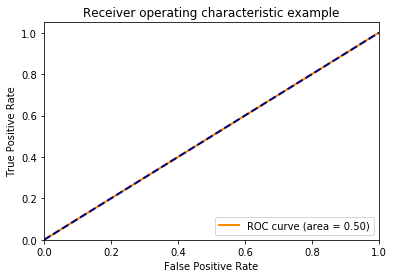

[[1215    0]
 [1499    0]]


In [6]:
def my_accuracy(y_true, y_pred):
    sliced_y_pred = tf.sigmoid(y_pred)
    y_pred_rounded = K.round(sliced_y_pred)
    acc = tf.equal(y_pred_rounded, y_true)
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))
    return acc
avg_auc = 0
T_B=len(test_list)//BATCH_SIZE
ys=np.zeros(len(test_list))
preds=np.zeros((len(test_list),1))
for i in range(T_B):
    x,y=test_generator.next()
    ys[i*BATCH_SIZE:(i)*BATCH_SIZE+len(y)] = y
    preds[i*BATCH_SIZE:(i)*BATCH_SIZE+len(y)] = model.predict(x)
from sklearn.metrics import auc
auc_score=sklearn.metrics.roc_auc_score(ys,preds)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc_score
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true, y_pred_rounded.eval(session=tf.Session()))
print(cm)

In [7]:
external_test_generator=get_test_batch(test2_list, batch_size=BATCH_SIZE)

In [8]:
from sklearn.metrics import accuracy_score
steps=len(test2_list)//BATCH_SIZE
print(steps)

y_true=np.zeros(len(test2_list))
y_pred=np.zeros((len(test2_list),1))
N=0
while N<len(test2_list):
    x_b, y_b = external_test_generator.next()
    pred_ = model.predict(x_b)
    y_p_b = pred_[:,0]
    #cm_p_b = pred_[:,3]
    y_true[N:N+len(y_b)]=y_b
    y_pred[N:N+len(y_p_b)]=y_p_b.reshape(len(y_b),1)
    N+=len(y_p_b)
y_true=y_true.reshape((len(test2_list),1))
acc = my_accuracy(y_true, y_pred).eval(session=tf.Session())
sliced_y_pred = tf.sigmoid(y_pred)
y_pred_rounded = K.round(sliced_y_pred)
acc_sc = accuracy_score(y_pred_rounded.eval(session=tf.Session()), y_true)
print('accuracy: ', acc_sc)

31
('accuracy: ', 0.5)


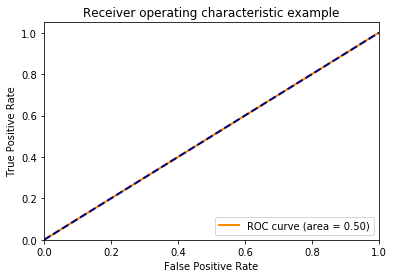

In [9]:
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

auc_score=sklearn.metrics.roc_auc_score(y_true,sliced_y_pred.eval(session=tf.Session()))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc_score
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()